In [ ]:
%%capture
# 한글 폰트 설치 및 환경 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 폰트 및 마이너스 기호 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

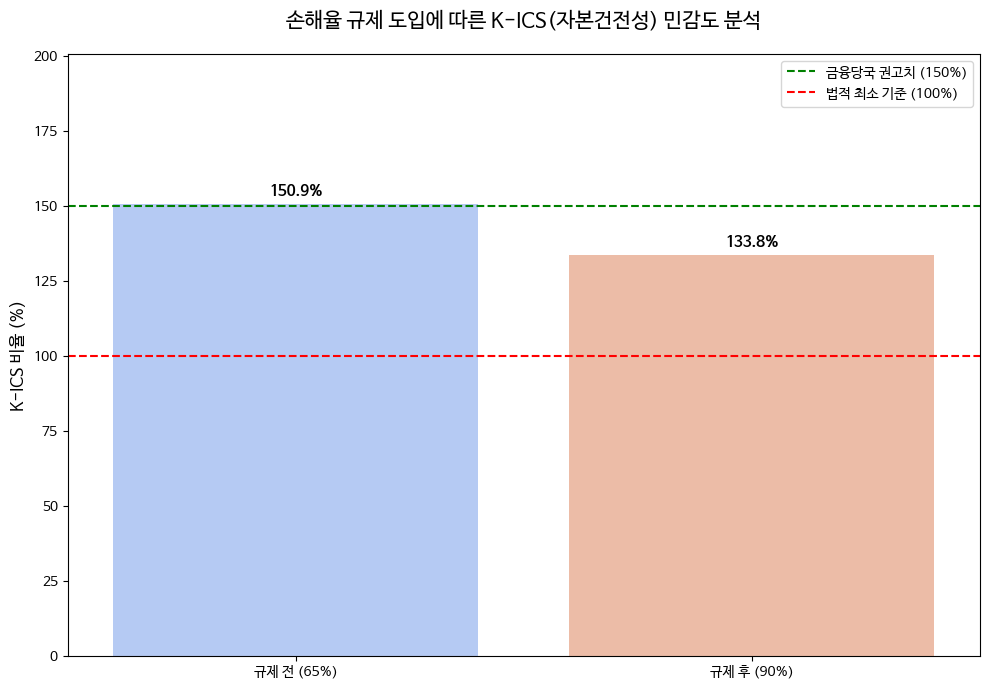

■ 규제 도입 전 예상 K-ICS 비율: 150.9%
■ 규제 도입 후 예상 K-ICS 비율: 133.8%
■ 자본 건전성 하락폭: 17.0%p


In [ ]:
# 1. 데이터 로드 및 머신러닝 모델링
df = pd.read_csv('insurance_sim_data.csv')

# 보험료, 사업비율 등 기초 지표를 활용하여 규제 시나리오 손해율 학습
X = df[['Premium', 'Expense_Ratio', 'Loss_Ratio_Old']]
y = df['Loss_Ratio_New']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 2. K-ICS(신지급여력제도) 스트레스 테스트 시나리오 구성
# 가용자본은 기초 자본에 Phase 3에서 산출한 시나리오별 당기 손익을 합산하여 산출
UNIT = 1e8
BASE_AVAILABLE_CAPITAL = 50 * UNIT  # 기초 가용자본 50억 가정
REQUIRED_CAPITAL = 35 * UNIT        # 요구자본 35억 가정

# 시나리오별 연간 이익 산출 로직 (IFRS17 CSM 상각 및 손실부담금 반영)
AMORT_RATE = 0.1
profit_old = (df['CSM_Old'] * AMORT_RATE).sum()
profit_new = (df['CSM_New'].apply(lambda x: x * AMORT_RATE if x > 0 else 0) - \
              df['CSM_New'].apply(lambda x: abs(x) if x < 0 else 0)).sum()

# K-ICS 비율 계산
kics_old = (BASE_AVAILABLE_CAPITAL + profit_old) / REQUIRED_CAPITAL * 100
kics_new = (BASE_AVAILABLE_CAPITAL + profit_new) / REQUIRED_CAPITAL * 100

# 3. 시각화 (FutureWarning 해결 버전)
plt.figure(figsize=(10, 7))
scenarios = ['규제 전 (65%)', '규제 후 (90%)']
kics_values = [kics_old, kics_new]

# x를 hue에 할당하고 legend=False로 설정하여 경고 제거
ax = sns.barplot(x=scenarios, y=kics_values, hue=scenarios, palette='coolwarm', legend=False)

# 금융당국 관리 기준선 설정
plt.axhline(150, color='green', linestyle='--', linewidth=1.5, label='금융당국 권고치 (150%)')
plt.axhline(100, color='red', linestyle='--', linewidth=1.5, label='법적 최소 기준 (100%)')

plt.title('손해율 규제 도입에 따른 K-ICS(자본건전성) 민감도 분석', fontsize=15, pad=20)
plt.ylabel('K-ICS 비율 (%)', fontsize=12)
plt.ylim(0, max(kics_values) + 50)

# 막대 상단에 데이터 라벨 표시
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height() + 3,
            f'{p.get_height():,.1f}%', ha="center", fontsize=11, fontweight='bold')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 4. 분석 결과 요약 출력
print(f"■ 규제 도입 전 예상 K-ICS 비율: {kics_old:,.1f}%")
print(f"■ 규제 도입 후 예상 K-ICS 비율: {kics_new:,.1f}%")
print(f"■ 자본 건전성 하락폭: {kics_old - kics_new:,.1f}%p")